In [1]:
from typing import Any, List, Optional, Tuple, Union
import numpy as np
from magic_pen.config import DEVICE
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform
from segment_any_change.embedding import (
    compute_mask_embedding,
    get_img_embedding_normed,
)
from segment_any_change.masks.mask_items import (
    FilteringType,
    ImgType,
    ListProposal,
)
from segment_any_change.matching import (
    BitemporalMatching,
    neg_cosine_sim,
)
import torch
import torchvision
from torch.nn import functional as F
import kornia as K
from segment_any_change.model import BiSam
from segment_any_change.sa_dev_v0.predictor import SamPredictor
from torch.utils.data import DataLoader
from segment_any_change.utils import *
import matplotlib.pyplot as plt
from magic_pen.config import project_path
from magic_pen.utils_io import make_path
import os

from segment_any_change.masks.mask_generator import SegAnyMaskGenerator
from segment_any_change.config_run import load_exp_params, choose_model

import logging

# TO DO : define globally
logging.basicConfig(format="%(asctime)s - %(levelname)s ::  %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [2]:
from segment_any_change.inference import partial_inference, infer_on_sample

In [3]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

In [4]:
img_B = load_img(path_B)
img_A = load_img(path_A)

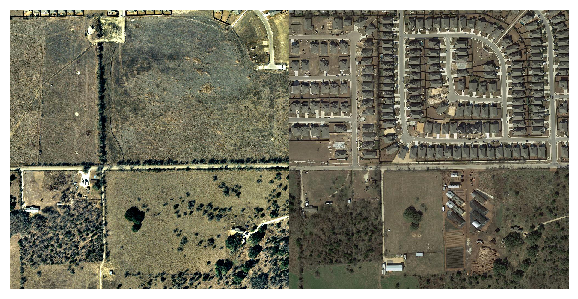

In [5]:
show_pair_img(img_A, img_B)

In [34]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=False,
    n_job_by_node=2,
    th_change_proposals=50
)
params = load_exp_params(**params)
print(params)
model = choose_model(is_debug=False, params=params)

output = infer_on_sample(A_path=path_A,
                B_path=path_B, 
                label_path=path_label,
                params=params,
                model=model)

2024-06-18 17:48:37,918 - INFO ::  build vit_h BiSam


ExperimentParams(model_type='vit_h', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr', ds_name='levir-cd', th_change_proposals=50, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', points_per_side=32, points_per_batch=64, pred_iou_thresh=0.88, stability_score_thresh=0.95, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240618_174837', exp_name='seganychange_repr', num_worker=2, n_job_by_node=2, dev=False)


2024-06-18 17:48:43,034 - INFO ::  === v2 ====


BATCH SIZE : 1 * 2
DTYPE input model torch.float32
Function forward Took 14.0654 seconds
sparse_embeddings: torch.Size([2, 1024, 2, 256])
dense_embeddings: torch.Size([2, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([2, 1024, 256, 64, 64])
pos_src : torch.Size([2, 1024, 256, 64, 64])
tokens : torch.Size([2, 1024, 7, 256])
Function predict_masks_batch Took 29.0627 seconds
OUT MODEL : torch.Size([2, 1024, 3, 256, 256])
filter iou_th : 2037
 filter stability_score : 576
 filter mask_threshold : 576
ATTACH 110 masks
filter iou_th : 1027


2024-06-18 17:49:26,421 - INFO ::  Function generate Took 43.3863 seconds


 filter stability_score : 456
 filter mask_threshold : 456
ATTACH 227 masks


2024-06-18 17:49:27,805 - INFO ::  Function temporal_matching_torch Took 1.3820 seconds
2024-06-18 17:49:30,587 - INFO ::  Function temporal_matching_torch Took 2.7808 seconds
2024-06-18 17:49:30,601 - INFO ::  Function proposal_matching_nms Took 0.0059 seconds
2024-06-18 17:49:30,779 - INFO ::  Function run Took 47.7437 seconds


NMS masks fusion
masks torch.Size([2, 227, 256, 256])
masks i A torch.Size([110, 256, 256])
masks i B torch.Size([227, 256, 256])
ci torch.Size([2, 227])
bboxes torch.Size([2, 227, 4])
ious torch.Size([2, 227])
masks_logits torch.Size([2, 227, 256, 256])


In [35]:
output.keys()

dict_keys(['pred', 'batch'])

In [36]:
output["batch"]["img_A"].shape

torch.Size([1, 3, 1024, 1024])

In [37]:
output["pred"]["masks"].shape

torch.Size([272, 1024, 1024])

In [38]:
masks = output["pred"]["masks"].cpu().squeeze(0)
label = output["batch"]["label"].cpu().squeeze(0)

In [39]:
def show_prediction_sample(output: Dict):
    masks = output["pred"]["masks"].cpu().squeeze(0)
    img_A = output["batch"]["img_A"].cpu().squeeze(0)
    img_B = output["batch"]["img_B"].cpu().squeeze(0)
    label = output["batch"]["label"].cpu().squeeze(0)

    if masks.ndim == 3:
        masks = torch.sum(masks, dim=0)
    fig, axs = plt.subplots(ncols=4, squeeze=False, figsize=(10, 10))
    
    for i, sample in enumerate(zip([img_A, img_B, label, masks], ["img_A", "img_B", "label", "masks_agg"])):
        img, name = sample
        if name.startswith("im"):
            img = to_numpy(img, transpose=True) / 255
            axs[0, i].imshow(img)

        else:
            img = to_numpy(img, transpose=False)
            axs[0, i].imshow(img, cmap="grey")

        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[0, i].set_title(name)

In [40]:
def get_metrics_units_counts(masks, label, eps=1e-5):
    """masks and labels need to be binary"""
    if masks.ndim > 2:
        masks = torch.sum(masks, axis=0).to(torch.int8)
    # ensure 0, 1 values
    MAX = torch.max(label)
    label = label / MAX
    
    output = masks.view(-1, )
    target = label.view(-1, ).float()

    tp = torch.sum(output * target)  # TP
    fp = torch.sum(output * (1 - target))  # FP
    fn = torch.sum((1 - output) * target)  # FN
    tn = torch.sum((1 - output) * (1 - target))  # TN

    return tp, fp, fn


def get_metrics_units_px(masks, label, eps=1e-5):
    """masks and labels need to be binary"""
    if masks.ndim > 2:
        masks = torch.sum(masks, axis=0).to(torch.int8)
    # ensure 0, 1 values
    MAX = torch.max(label)
    label = label / MAX

    tp = masks * label  # TP
    fp = masks * (1 - label) # FP
    fn = (1 - masks) * label  # FN
    return tp, fp, fn

def plot_metrics_units_px(tp, fp, fn, title="Metrics Overlay"):

    overlay = np.zeros((*tp.shape, 3), dtype=np.uint8)
    tp = to_numpy(tp, transpose=False)
    fp = to_numpy(fp, transpose=False)
    fn = to_numpy(fn, transpose=False)

    # tps in green - we keep masks summed
    overlay[tp >= 1] = [0, 255, 0]
    
    # fn in red
    overlay[fn >= 1] = [255, 0, 0]
    
    # fp orange
    overlay[fp >= 1] = [255, 165, 0]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay, alpha=0.5)  # overlay with transparency
    plt.title(title)
    plt.axis('off')
    plt.show()

    # pixel_acc = (tp + tn + self.eps) / (tp + tn + fp + fn + self.eps)
    #     dice = (2 * tp + self.eps) / (2 * tp + fp + fn + self.eps)
    #     precision = (tp + self.eps) / (tp + fp + self.eps)
    #     recall = (tp + self.eps) / (tp + fn + self.eps)
    #     specificity = (tn + self.eps) / (tn + fp + self.eps)


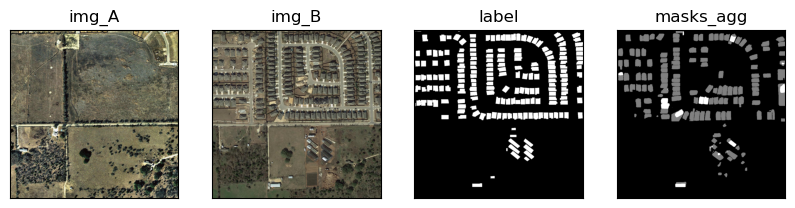

In [41]:
# th 60
show_prediction_sample(output)

torch.Size([272, 1024, 1024])


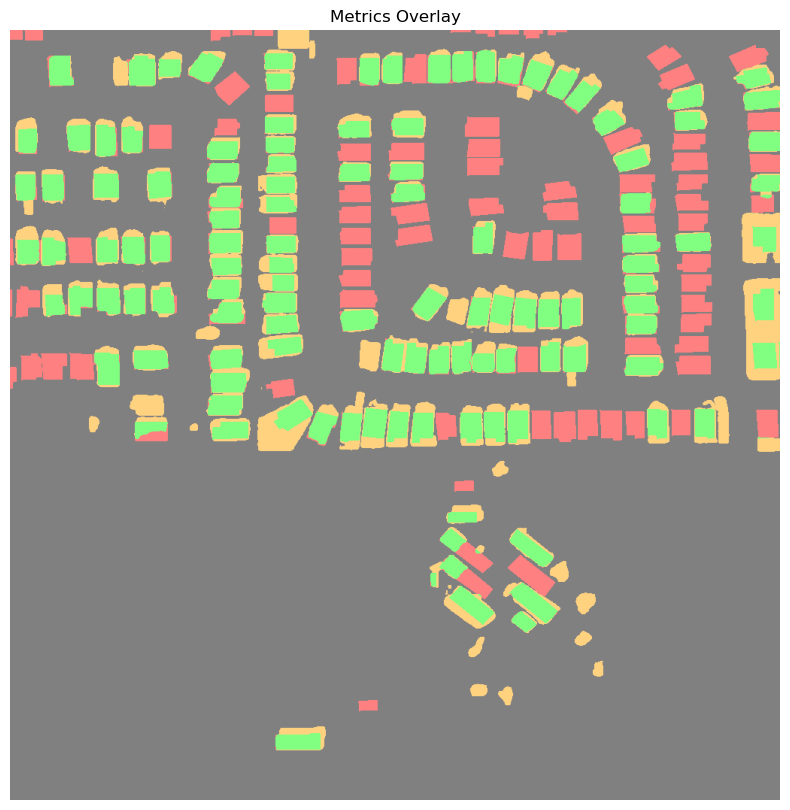

In [42]:
# th 0
print(masks.shape)
tp, fp, fn = get_metrics_units_px(masks, label)
plot_metrics_units_px(tp, fp, fn, title="Metrics Overlay")

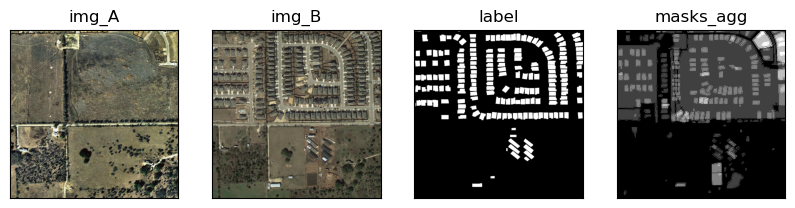

In [42]:
# th 40
show_prediction_sample(output)

torch.Size([354, 1024, 1024])


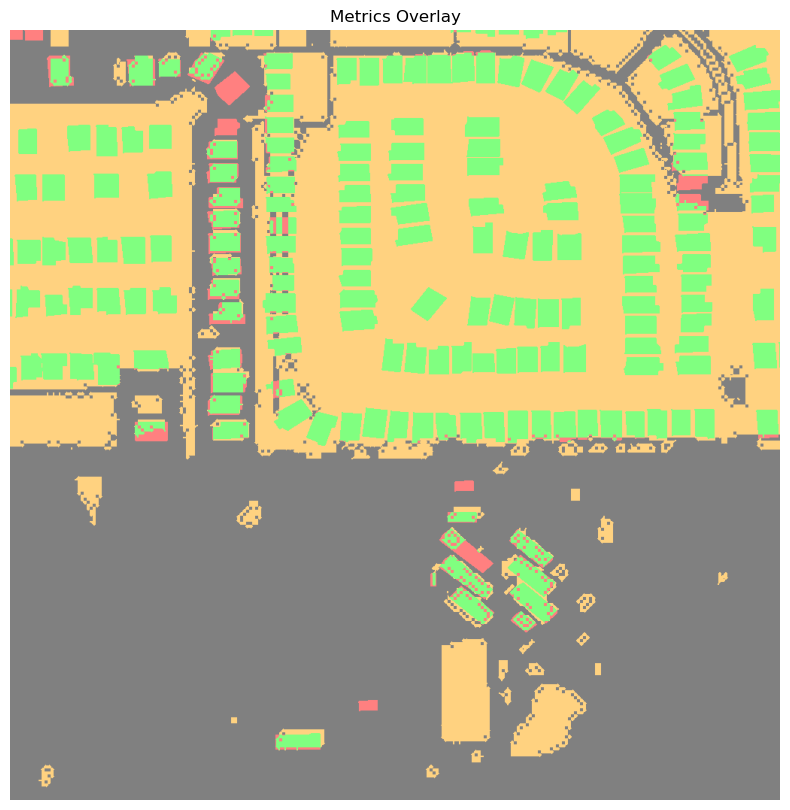

In [43]:
# th 40
print(masks.shape)
tp, fp, fn = get_metrics_units_px(masks, label)
plot_metrics_units_px(tp, fp, fn, title="Metrics Overlay")

In [16]:
from segment_any_change.config_run import ExperimentParams, choose_model, load_default_metrics, load_exp_params
from segment_any_change.eval import MetricEngine

in_metrics = load_default_metrics(**params.engine_metric)
return_batch = True

engine_eval = MetricEngine(in_metrics=in_metrics)
preds, batch = output["pred"], output["batch"]
metrics = engine_eval(preds, batch["label"])
out = {
    "pred": preds,
    "metrics": metrics,
    "batch": batch if return_batch else None,
}

TypeError: MetricEngine.__init__() missing 1 required positional argument: 'name'

In [14]:
metrics

{'BinaryF1Score': tensor(0.5630),
 'BinaryPrecision': tensor(0.6536),
 'BinaryRecall': tensor(0.4945),
 'BinaryJaccardIndex': tensor(0.3918),
 'UnitsMetricCounts': {'tp_indices': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float16),
  'fp_indices': tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float16),
  'fn_indices': tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           

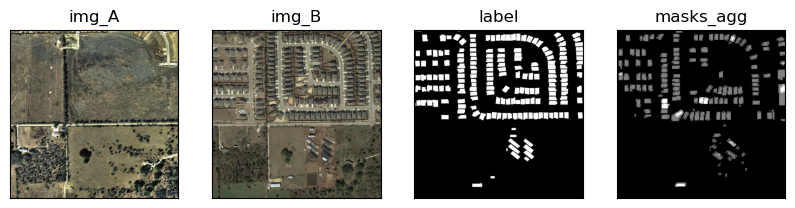

In [33]:
# th 50
show_prediction_sample(output)

torch.Size([284, 1024, 1024])


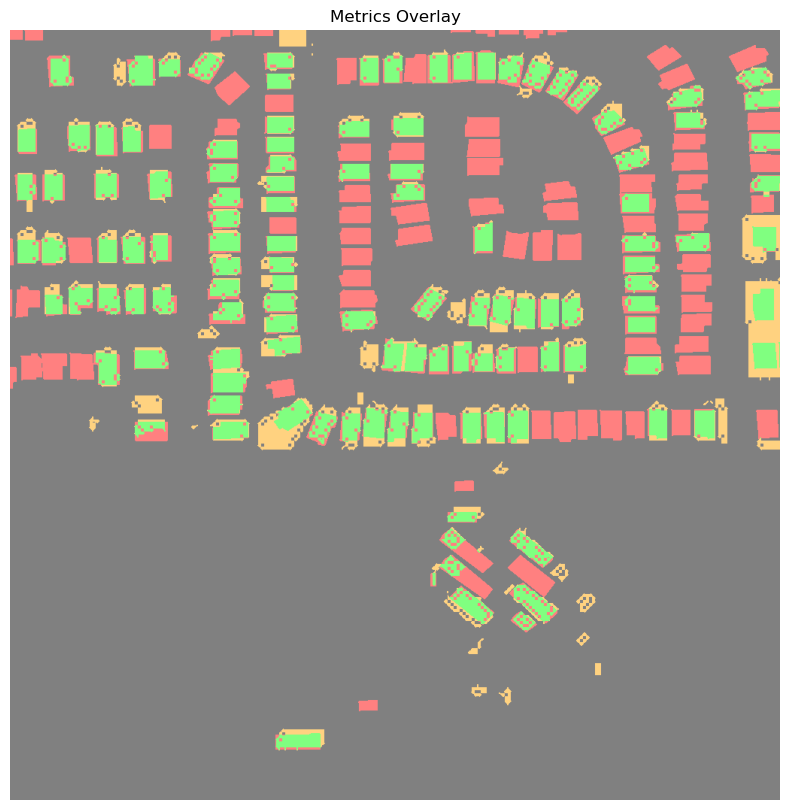

In [36]:
# th 50
print(masks.shape)
tp, fp, fn = get_metrics_units_px(masks, label)
plot_metrics_units_px(tp, fp, fn, title="Metrics Overlay")

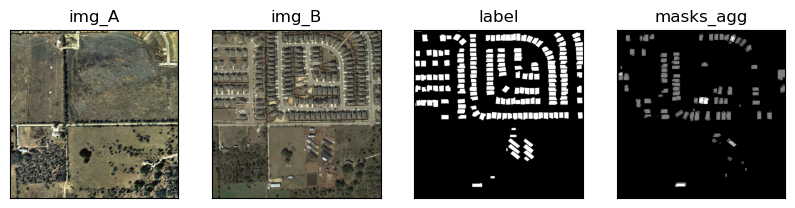

In [22]:
# th 60
show_prediction_sample(output)

torch.Size([170, 1024, 1024])


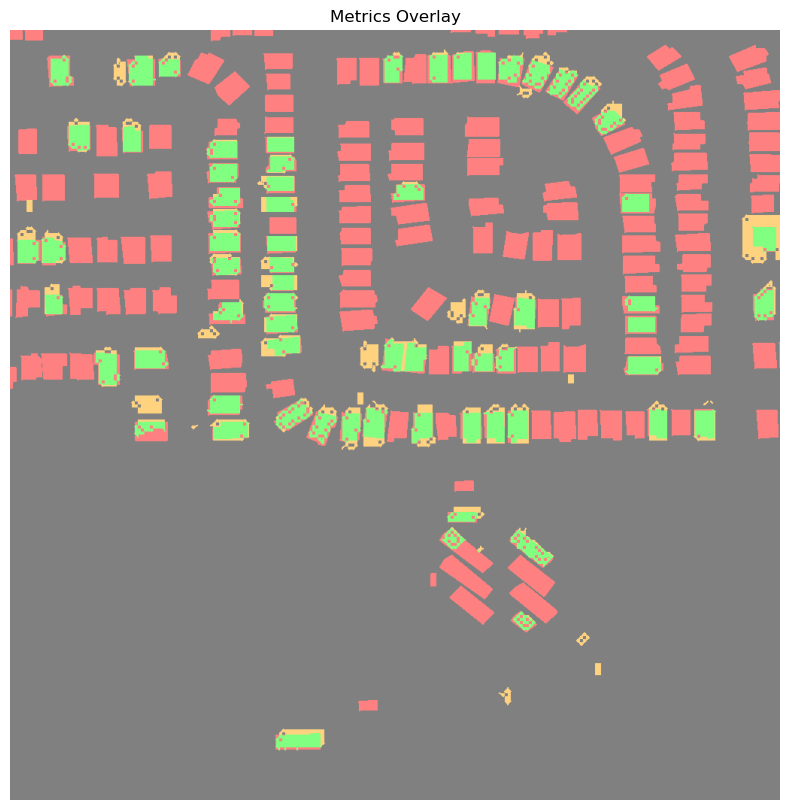

In [21]:
print(masks.shape)
tp, fp, fn = get_metrics_units_px(masks, label)
plot_metrics_units_px(tp, fp, fn, title="Metrics Overlay")

torch.Size([320, 1024, 1024])


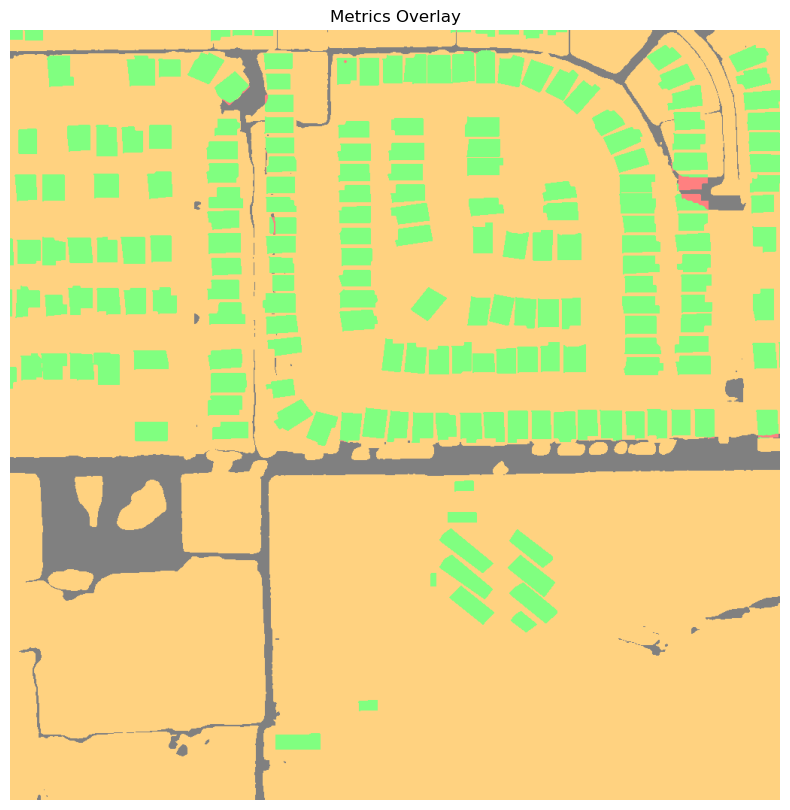

In [13]:
print(masks.shape)
tp, fp, fn = get_metrics_units_px(masks, label)
plot_metrics_units_px(tp, fp, fn, title="Metrics Overlay")

In [51]:
import torch
from torchmetrics.classification import (
    BinaryF1Score,BinaryAccuracy,    BinaryPrecision,
    BinaryRecall,
)
class MyMetricCollection(MetricCollection):
    def update(self, preds, target):
        for name, metric in self.items():
            # update the metric with some predictions and targets
            metric.update(preds, target)
            # access the current metric being updated
            if name == 'BinaryPrecision':
                # do something with the current metric
                current_metric = metric.compute()
                print(f'Current metric: {name}, value: {current_metric}')

# create a MetricCollection with multiple metrics
metrics = MyMetricCollection({
    'BinaryPrecision': BinaryPrecision(),
    'BinaryRecall': BinaryRecall(),
})

# assume we have some predictions and targets
preds = torch.tensor([0, 0, 0, 1])
target = torch.tensor([0, 1, 1, 1])

# update the metrics with some predictions and targets
metrics.update(preds, target)

Current metric: BinaryPrecision, value: 1.0


In [37]:
from torchmetrics import Metric, MetricCollection
from torchmetrics.classification import (
    BinaryF1Score,BinaryAccuracy,    BinaryPrecision,
    BinaryRecall,
)
metrics = MetricCollection([BinaryF1Score(),BinaryAccuracy(), BinaryPrecision()])

In [52]:
for m in metrics:
    print(metrics.items())

odict_items([('BinaryPrecision', BinaryPrecision()), ('BinaryRecall', BinaryRecall())])
odict_items([('BinaryPrecision', BinaryPrecision()), ('BinaryRecall', BinaryRecall())])


In [42]:
metrics

MetricCollection(
  (BinaryF1Score): BinaryF1Score()
  (BinaryAccuracy): BinaryAccuracy()
  (BinaryPrecision): BinaryPrecision()
)

In [34]:
for m in metrics:
    print(type(m).__name__)

str
str


In [17]:
torch.tensor(np.zeros((167, 1024, 1024))).shape

torch.Size([167, 1024, 1024])

In [20]:
tmp = torch.tensor(np.zeros((1024, 1024)))
tmp[:10, :10] = 1.

In [23]:
tmp = torch.tensor(np.zeros((1024, 1024)))
tmp[m] = 1.

In [25]:
tmp.shape

torch.Size([1024, 1024])

In [22]:
m = torch.nonzero(tmp, as_tuple=False)

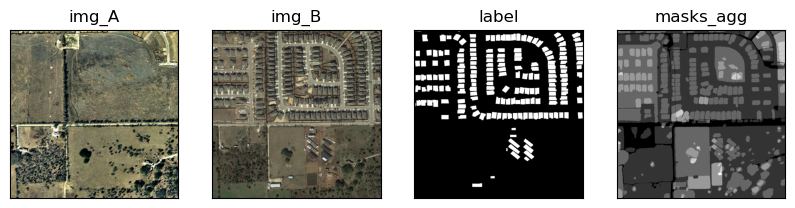

In [21]:
show_prediction_sample(output)

* Issue, not same as before. Check bug

### Check objects generation

In [23]:
params.points_per_side

32

In [2]:
import torch
l = []
t = torch.zeros((10, 10))
torch.stack([t, l])

TypeError: expected Tensor as element 1 in argument 0, but got list

In [7]:
params = load_default_sam_params()

sam = load_sam(
            model_type=params.model_type, 
            model_cls=BiSam,
            version="dev", 
            device=DEVICE
            )

mask_generator = SegAnyMaskGenerator(sam,
                                    points_per_side=params.points_per_side,
                                    points_per_batch=params.points_per_batch,
                                    pred_iou_thresh=params.pred_iou_thresh,
                                    stability_score_thresh=params.stability_score_thresh,
                                    stability_score_offset=params.stability_score_offset,
                                    box_nms_thresh=params.box_nms_thresh,
                                    min_mask_region_area=params.min_mask_region_area)


item = DataSample(A_path=path_A, 
                    B_path=path_B, 
                    label_path=path_label)
    
ds = BiTemporalDataset(items=item, transform=DefaultTransform())
dloader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False)
batch = next(iter(dloader))


img_anns = mask_generator.generate(batch)


2024-06-03 09:05:16,047 - INFO ::  build BiSam


torch.Size([1, 3, 1024, 1024])
BATCH SIZE : 1
Function forward Took 3.8108 seconds
sparse_embeddings: torch.Size([2, 1024, 2, 256])
dense_embeddings: torch.Size([2, 1024, 256, 64, 64])

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([2, 1024, 5, 256])
tokens shape : torch.Size([2, 1024, 7, 256])
img_embedding (src) : torch.Size([2, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([2, 1024, 256, 64, 64])
pos_src : torch.Size([2, 1024, 256, 64, 64])
tokens : torch.Size([2, 1024, 7, 256])
- In transf src : torch.Size([2, 1024, 4096, 256])
- In transf image_pe : torch.Size([2, 1024, 4096, 256])
out transformer
hs shape : torch.Size([2, 1024, 7, 256])
src shape : torch.Size([2, 1024, 4096, 256])
iou out shape : torch.Size([2, 1024, 256])
masks tokens out shape : torch.Size([2, 1024, 4, 256])
upscaled src tokens out shape : torch.Size([2, 1024, 32, 256, 256])
hyper in shape : torch.Size([2, 1024, 4, 32])
 mask_low : torch.Size([2, 1024, 4, 256, 256])
Function

2024-06-03 09:05:53,699 - INFO ::  Function generate Took 36.3623 seconds


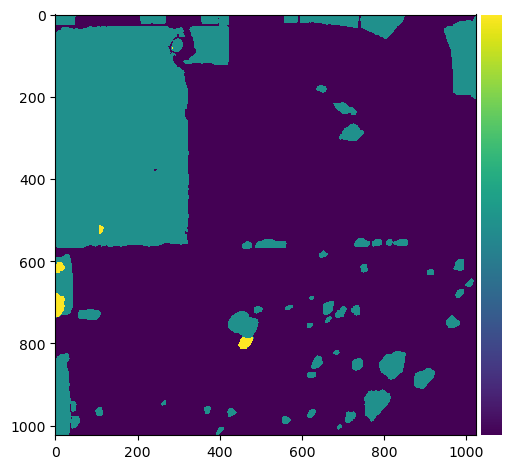

In [8]:
m = np.stack(img_anns[0]["masks"])
show_img(np.sum(m, axis=0))

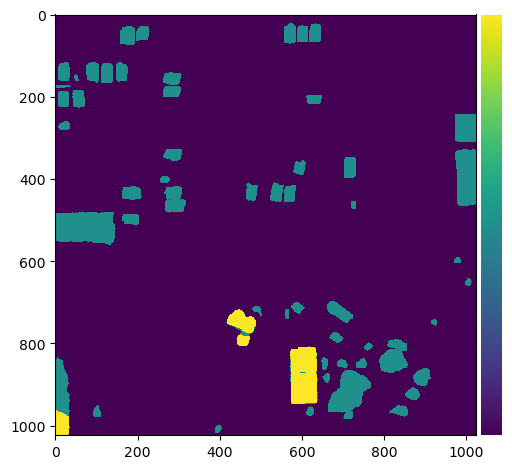

In [9]:
m = np.stack(img_anns[1]["masks"])
show_img(np.sum(m, axis=0))

check with old generation obj

In [9]:
batch["img_B"][0].shape

torch.Size([3, 1024, 1024])

In [17]:
from segment_any_change.sa_dev_v0 import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
from segment_any_change.sa_dev_v0.modeling import Sam

params = load_default_sam_params()

sam = load_sam(
            model_type=params.model_type, 
            version="raw", 
            device=DEVICE
            )

mask_generator = SamAutomaticMaskGenerator(sam)

item = DataSample(A_path=path_A, 
                    B_path=path_B, 
                    label_path=path_label)
    
ds = BiTemporalDataset(items=item, transform=DefaultTransform())
dloader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False)
batch = next(iter(dloader))

img_B = to_numpy(batch["img_B"][0], transpose=True).astype(np.uint8)
img_A = to_numpy(batch["img_A"][0], transpose=True).astype(np.uint8)
masks = mask_generator.generate(img_A)

2024-06-03 09:03:11,626 - INFO ::  build SAM


in points shape : torch.Size([64, 1, 2])
---- start predict torch ----
sparse emb : torch.Size([64, 2, 256])
dense emb : torch.Size([64, 256, 64, 64])
img emb : torch.Size([1, 256, 64, 64])
init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([64, 5, 256])
tokens shape : torch.Size([64, 7, 256])
src first interleave shape : torch.Size([64, 256, 64, 64])
src shape : torch.Size([64, 256, 64, 64])
src dense_prompt_embeddings : torch.Size([64, 256, 64, 64])
src add dense : torch.Size([64, 256, 64, 64])
out transformer
hs shape : torch.Size([64, 7, 256])
src shape : torch.Size([64, 4096, 256])
iou out shape : torch.Size([64, 256])
masks tokens out shape : torch.Size([64, 4, 256])
 mask_low : torch.Size([64, 4, 256, 256])
low mask  predict torch : torch.Size([64, 3, 256, 256])
low mask  predict torch : torch.Size([64, 3, 1024, 1024])
predict torch - mode auto output
out decoder masks raw shape : torch.Size([64, 3, 1024, 1024])
out decoder iou raw shape : torch.Size([64, 3

In [15]:
masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

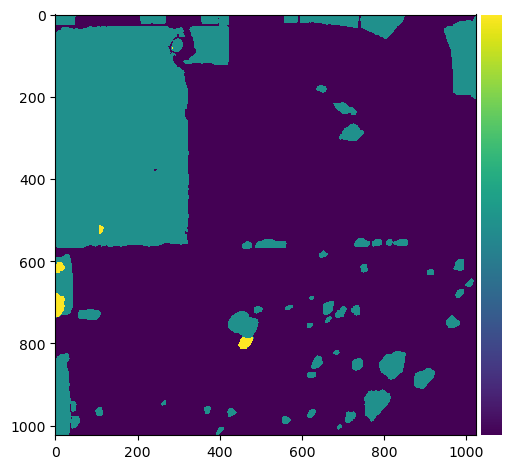

In [18]:
# img_B
m = np.stack([m["segmentation"] for m in masks])
show_img(np.sum(m, axis=0))

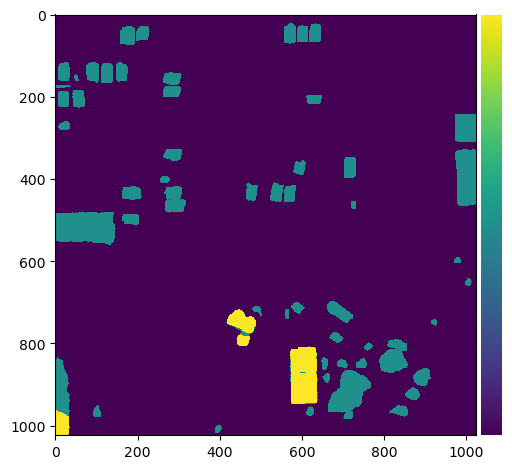

In [16]:
# img_B
m = np.stack([m["segmentation"] for m in masks])
show_img(np.sum(m, axis=0))